<h1>TDF Time Signal</H1>

# Introduction

TéléDiffusion de France broadcast the TDF time signal, controlled by LNE–SYRTE, from the Allouis longwave transmitter at 162 kHz, with a power of 800 kW.<br>
The time signal is transmitted on the former carrier of France's France Inter longwave AM radio station on 162 kHz. The carrier is phase modulated in 0.1 second every second, except for the 59th second of each minute. The data encoded in this signal is similar to DCF77, except for bit 13 and 14, which are set for holidays.<br>
<br>
The signal is modulated in a way where it is inaudible and unnoticeable when listening to the radio station normally with AM.<br>
The recorded signal used in this notebook is in RAW I/Q signal. When the signal is received in USB mode with the bandwidth and IF set so that only the carrier is in the passband, a slight phase shifts in the carrier can be heard, as opposed to a constant CW carrier.<br>
<br>
More information can be found on <a href="https://www.sigidwiki.com/wiki/TDF">sigidwiki</a> and on the <a href="https://en.wikipedia.org/wiki/TDF_time_signal">wikipedia</a>.<br>
<br>
This jupyter notebook is a first exercise on decoding PSK signals. The TDF time signal was choses as this is a very slow PSK signal with a fixed slow-moving change of phase with a fixed pattern. Due to the slow and well-known PSK signal, the PSK demodulation will be done by detecting the change in phase, not the phase itself. <br>
The goal of this notebook is to detect and decode the PSK signals. but not to decode the actual time-signal information.

## Part 1: Preparations
### Loading libraries

In [ ]:
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
%matplotlib inline

# schitt-trigger class 
from schmitt import schmitt

### global variables

In [ ]:
samp_rate=48000.0

### load i/q data
<br>
Note: The datafile is a recording of RDF transmitter, containing iq sample-data. The recording was done with gqrx in "raw-iq" receiver-mode, a SDRplay RSD-dx and an active miniwhip antenna. Using linux pulseaudio, the audio of gqrx was the piped into a GNU Radio flowgraph that converted the audio into a file of i/q data in float32 format.<br>
The sample-rate is 48 Ksamples/second. We limit the data to 120 seconds

In [ ]:
numsec=120
d=np.fromfile("tdf_120s.f32",dtype=np.complex64,offset=0,count=int(samp_rate*numsec))

### Examining the data
Let's make a spectrogram (horizontal waterfall)<br>

In [ ]:
ax = plt.axes()
ax.specgram(d, Fs=48000, scale='dB')
plt.show()

## Frequency correction
Apparently, we need to do a frequency correction. Let's first determine the frequency offset. As the signal starts from the beginning of the sample-data, we can use the trick as discussed in the EFR_teleswitch notebook: make a FFT of the very start of the signal.

In [5]:

numbins=2**18
f=np.fft.fftshift(np.fft.fft(d,n=numbins))
maxbin=f=np.argmax(np.fft.fftshift(np.fft.fft(d.real,n=numbins)))
print("frequency:",samp_rate*(maxbin/numbins)-(samp_rate/2))


frequency: 1900.45166015625


### downconvert to 0 Hz
Generare a tone of -1900 Hz, mixed that with the received signal and plot the result

In [6]:
tone_freq=-samp_rate*(maxbin/numbins)-(samp_rate/2)+1
tone_t=np.linspace(0,numsec*tone_freq*2*np.pi,int(numsec*samp_rate), endpoint=False)
tone_s=np.cos(tone_t)+np.sin(tone_t)*1j

dmixed=d*tone_s

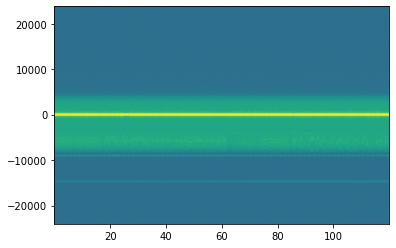

In [7]:
ax = plt.axes()
ax.specgram(dmixed, Fs=48000, scale='dB')
plt.show()

## Downsample to 800 Samples / second
This will make the data more easy to process

In [12]:
decim=60
ddownsamp=scipy.signal.resample_poly(dmixed,1,decim)

samp_rate_2=int(samp_rate/decim)
t=np.linspace(0,numsec,samp_rate_2*numsec) # timescale .. used for plotting

# Part 2: Analysing the signal
Let's take a look at the signal: the signal itself, and the amplitude, frequency and phase.<br>
We will zoom into the 3 seconds, from second 24 to 27.

In [89]:
amdemod=np.abs(ddownsamp)**2
ph=np.angle(ddownsamp)

# note: this code replaces the "subtract angle from previous angle" code (as used in the EFR) exercise
#       with the numpy "diff" and "where" functions 
pi=np.pi
pi2=np.pi*2
fmdemod=np.diff(ph)
for i in np.where(fmdemod>pi)[0]: fmdemod[i] -= pi2

for i in np.where(fmdemod<-pi)[0]: fmdemod[i] += pi2



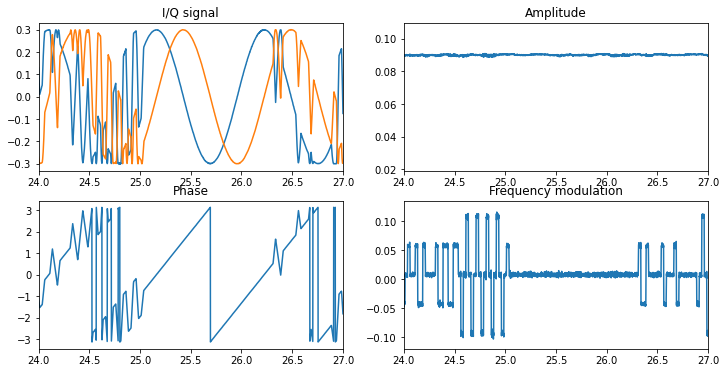

In [56]:
# create the plot

fig, axs = plt.subplots(2, 2)

# the signal itself
trgt=axs[0,0]
trgt.plot(t,ddownsamp.real)
trgt.plot(t,ddownsamp.imag)
trgt.set_title("I/Q signal")
trgt.set_xlim(24,27)

# amplitude
trgt=axs[0,1]
trgt.plot(t,amdemod)
trgt.set_title("Amplitude")
trgt.set_xlim(24,27)

# phase
trgt=axs[1,0]
trgt.plot(t,ph) # fm demodulation redunces the number of samples by 1
trgt.set_title("Phase")
trgt.set_xlim(24,27)
# frequency

trgt=axs[1,1]
trgt.plot(t[1:],fmdemod) # fm demodulation redunces the number of samples by 1
trgt.set_title("Frequency modulation")
trgt.set_xlim(24,27)


# figure size
fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

What do we see?<br>
- The signal carries a digital signal, except from timestamp 25 to 26.3.
- the iq-signal itself is quite a mess and difficult to process.
- The applitude of the signal is constant and does not carry any information, so is useless for us.
- Both the Phase signal and the FM demodulated signal (i.e. difference-in-phase over time) look interesting

### Examine the phase (angle)
The phase signal clearly caries the databits being transmitted. Let's look at what it should look like according the documentation:<br>
Information on <a href="https://www.sigidwiki.com/wiki/TDF">sigidwiki</a> and <a href="https://en.wikipedia.org/wiki/TDF_time_signal#Phase_modulation_pattern"> wikipedia</a><br><br>
Let's zoom in a little bit more.

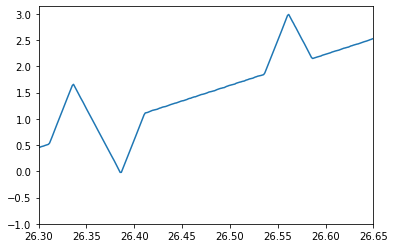

In [85]:
plt.plot(t,ph)
plt.xlim(26.3,26.65)
plt.ylim(-1,pi)
plt.show()

There is clearly a pattern in this, but there is also a linear 'ramp' going upwards. That ramp is the result of a small difference in frequency between the transmitter and the receiver. Let's try to get rid of it so we can see the phase-modulation.<br>
The trick to do is to add an additional 'negative ramp' to the signal that counters the error.

[]

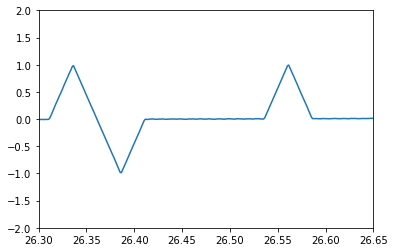

In [87]:
phcorr=np.linspace(-4.3,700,96000)  # these values have been detmermined by trial and error
plt.plot(t,ph-phcorr+149.6) # the correction factor of 149.4 has been detmermined by trial and error
plt.xlim(26.3,26.65) # these values have been detmermined by trial and error
plt.ylim(-2,2) # these values have been detmermined by trial and error
plt.plot()

This nicely shows the signal as described in the wikipedia article: a "bit" is:
- 25 ms lineair phase-shift from 0 to +1 radius
- 50 ms lineair phase-shift from +1 to -1 radius
- 25 ms lineair phase-shift from +1 to 0 radius


Now, let's look at the FM demodulation signal for the same periode.

[]

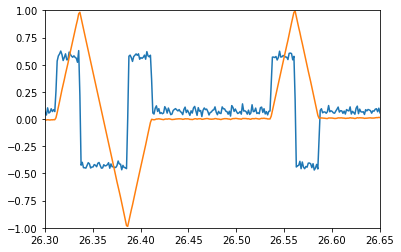

In [83]:
plt.plot(t[1:],fmdemod*10) # scale up by 10 for clarity
plt.plot(t,ph-phcorr+149.6)
plt.xlim(26.3,26.65)
plt.ylim(-1,1)
plt.plot()

As can be seen, as the phase-change over time is lineair, they become visible as positive and negative squarewave pulses.<br>
<br>
Also note the slight offset of the FM demodulated signal above 0, which is the result of the slight difference in frequency between the transmitter and the receiver. In the phase plot, this was shown as the 'ramp'.<br>
As the FM demodulated signal is more easy to decode, we'll continue using that signal.

# Part 3: Extracting the bits

## Clean up the signal

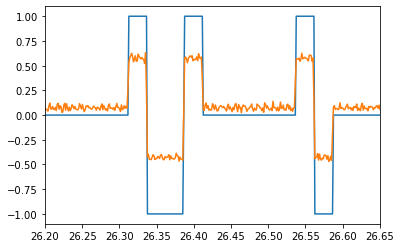

In [117]:
#note: the schmitt-trigger class has been moved to a seperate source-file and is imported above
st=schmitt(0.015,0.035)
b=np.array([st.next(abs(x)) for x in fmdemod])
p=np.sign(fmdemod) # polarity

fm1=p*b

plt.plot(t[1:],fm1)
plt.plot(t[1:],fmdemod*10) # scale up by 10 for clarity
plt.xlim(26.2,26.65)
plt.ylim(-1.1,1.1)
plt.show()

## Extract the bits


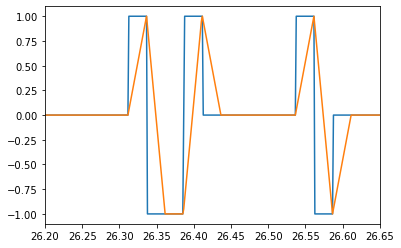

In [122]:
# sample rate is 800 sps/ bitrate is 40 bits/second, so 20 samples per bit
# convolute on 20 samples
# we will use this to best determine the end of a bit

bit20=np.ones(20)
fm2=np.convolve(fm1,bit20)/20

plt.plot(t[1:],fm1)
plt.plot(t[1:],fm2[:-19])
plt.xlim(26.2,26.65) # starting from the beginning of the stream 
plt.ylim(-1.1,1.1)
plt.show()



### Find the start of the stream and extract bits from there on
For that, we need to find the first falling-edge of the signal.<br>
<br>
We'll limit the search to the first 2 seconds as the bitstreams should at least start in the first two seconds. This limits the resources that are needed.

In [154]:
first2sec=fm2[:1600] # the bitstreams should at least start in the first two seconds

# find first falling edge
first2sec_d=np.diff(first2sec) # find edges
firstfallingedge=np.where(first2sec_d < 0)[0][0]


# this code is a variation of the code used in the EFR exercise.
# it determine the position of the peak of fm2 (convoluded) signal and moves the pointer up by 19, 20 or 22 samples
# based on that.

l = len(fm1) - 20 # length of complete stream, subtrack 20 for last bit
p = firstfallingedge # pointer

received=[]

printdebug=False

while p < l:
        # first find end of bit, then get data
        
        # the end-of-bit is 20 samples after the end, so get samples 18,19,20,21,22 
        c=fm2[p+18:p+23]

        lower=c[0]+c[1]
        mid=c[2]
        higher=c[3]+c[4]

        prevp=p

        # get sample halfway the bit to determine if the bit is above or below 0 
        invert = 0 if fm2[p+10] > 0 else 1

        # above the zero-line
        if (lower == higher):
                # fm1 is in balance, move up 40 samples for 1 bit
                p+=20
        elif (lower > higher):
                if abs(mid) > 0.5:
                        p+=(19,21)[invert]
                else:
                        # mid < 0.5
                        p+=(21,19)[invert]
                #end if
        else:
                # higer > lower
                if abs(mid) > 0.5:
                        p+=(21,19)[invert]
                else:
                        # mid < 0.5
                        p+=(19,21)[invert]
                #end if
        #end if 
        
        # p has already been moved up by 20 (or 19 or 21),
        #    so subtrack half a bit (10 samples) to get the correct value
        v = round(fm1[p-10])
        received.append(v)
       
        if printdebug: print(prevp,v,c,p)
#end while

r=np.array(received)




## Find the second-59 marker
The second-59 marker is 1 full second of no phase shift. As we have one 40 phase-bit per second, so need to look for 40 '0'


### Methode 1: convolution

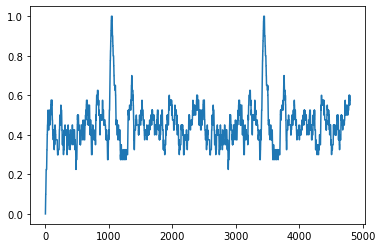

In [155]:
#invert the bits, so we can do a convolute
r2=1-abs(r)

bit40=np.ones(40)
r3=(np.convolve(r2,bit40)[:-40])/40

plt.plot(r3)
plt.show()


In [177]:
maxvalue=r3.max()
sec59=np.where(r3 == maxvalue)[0]
print(sec59)

[1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 3440 3441
 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451]


### Methode 2: finding zero's

In [176]:
zeros40=np.zeros(40)
r21 = [(r[x:x+40] == zeros40).all() for x in range(len(r)-40)]


start21=np.argmax(r21)
start22=np.argmax(r[start21+40:])

startpacket=start21+40+start22

print(startpacket)


1052


# Part 4: decoding the time information

The time-information is encoded in the first two 4-bit PSK bits:
- 1 -1 -1  1    0  0  0  0 -> 0
- 1 -1 -1  1    1 -1 -1  1 -> 1

here are the first 10 bits

In [183]:
for x in range(10): print(r[startpacket+x*40:startpacket+8+x*40])
print("...")

[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  1 -1 -1  1]
[ 1 -1 -1  1  1 -1 -1  1]
[ 1 -1 -1  1  1 -1 -1  1]
[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  0  0  0  0]
[ 1 -1 -1  1  0  0  0  0]
...


### Actual contents of the time data:<br>
(see format description on <a href="https://en.wikipedia.org/wiki/TDF_time_signal#Signal_format">wikipedia</a>)
<pre>
[ 1 -1 -1  1  0  0  0  0] START
[ 1 -1 -1  1  0  0  0  0] POS LEAP
[ 1 -1 -1  1  0  0  0  0] NEG LEAP
[ 1 -1 -1  1  1 -1 -1  1] HAMMING
[ 1 -1 -1  1  1 -1 -1  1] HAMMING
[ 1 -1 -1  1  1 -1 -1  1] HAMMING
[ 1 -1 -1  1  0  0  0  0] HAMMING
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  0  0  0  0] PUBLIC HOLIDAY NEXT DAY
[ 1 -1 -1  1  0  0  0  0] PUBLIC HOLIDAY CURRENT DAY
[ 1 -1 -1  1  0  0  0  0] IGNORE
[ 1 -1 -1  1  0  0  0  0] SUMMER DAY ANNOUNCE
[ 1 -1 -1  1  0  0  0  0] CEST IS ACTIVE
[ 1 -1 -1  1  1 -1 -1  1] CET IS ACTIVE
[ 1 -1 -1  1  0  0  0  0] UNUSED
[ 1 -1 -1  1  1 -1 -1  1] START
[ 1 -1 -1  1  0  0  0  0] MIN 1 : 20
[ 1 -1 -1  1  0  0  0  0] MIN 2
[ 1 -1 -1  1  0  0  0  0] MIN 4
[ 1 -1 -1  1  0  0  0  0] MIN 8
[ 1 -1 -1  1  0  0  0  0] MIN 10
[ 1 -1 -1  1  1 -1 -1  1] MIN 20
[ 1 -1 -1  1  0  0  0  0] MIN 40
[ 1 -1 -1  1  1 -1 -1  1] MIN (PARITY)
[ 1 -1 -1  1  1 -1 -1  1] HOUR 1 : 1 + 20 = 21
[ 1 -1 -1  1  0  0  0  0] HOUR 2
[ 1 -1 -1  1  0  0  0  0] HOUR 4
[ 1 -1 -1  1  0  0  0  0] HOUR 8
[ 1 -1 -1  1  0  0  0  0] HOUR 10
[ 1 -1 -1  1  1 -1 -1  1] HOUR 20
[ 1 -1 -1  1  0  0  0  0] HOUR (PARITY)
[ 1 -1 -1  1  0  0  0  0] DAY-OF-MONTH 1 : 2 + 4 + 10 = 16
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-MONTH 2
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-MONTH 4
[ 1 -1 -1  1  0  0  0  0] DAY-OF-MONTH 8
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-MONTH 10
[ 1 -1 -1  1  0  0  0  0] DAY-OF-MONTH 20
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-WEEK 1 : 1 + 2 + 4 = 7 = Sunday
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-WEEK 2
[ 1 -1 -1  1  1 -1 -1  1] DAY-OF-WEEK 4
[ 1 -1 -1  1  1 -1 -1  1] MONTH 1 : 1
[ 1 -1 -1  1  0  0  0  0] MONTH 2
[ 1 -1 -1  1  0  0  0  0] MONTH 4
[ 1 -1 -1  1  0  0  0  0] MONTH 8
[ 1 -1 -1  1  0  0  0  0] MONTH 10
[ 1 -1 -1  1  0  0  0  0] YEAR 1 : 20 + 2 = 22
[ 1 -1 -1  1  1 -1 -1  1] YEAR 2
[ 1 -1 -1  1  0  0  0  0] YEAR 4
[ 1 -1 -1  1  0  0  0  0] YEAR 8
[ 1 -1 -1  1  0  0  0  0] YEAR 10
[ 1 -1 -1  1  1 -1 -1  1] YEAR 20
[ 1 -1 -1  1  0  0  0  0] YEAR 40
[ 1 -1 -1  1  0  0  0  0] YEAR 80
[ 1 -1 -1  1  1 -1 -1  1] PARITY
</pre>

